In [162]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font",family='Kai')
plt.rcParams['axes.unicode_minus'] =False
from pyqpanda import *
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

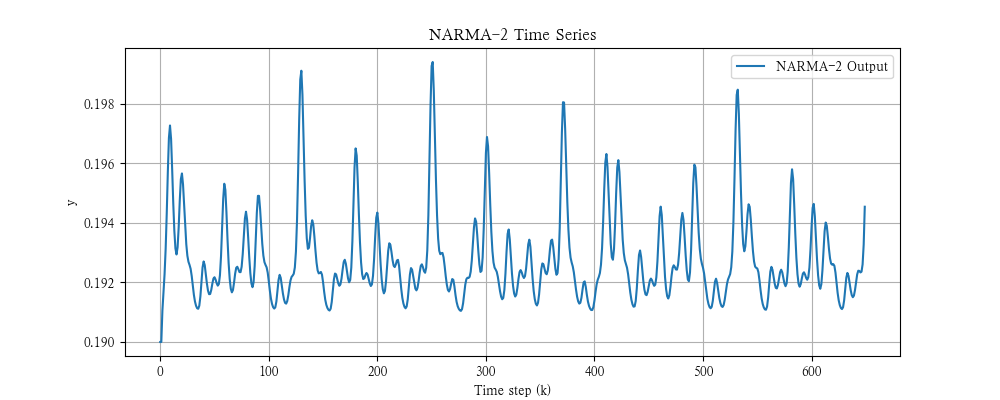

In [163]:
# 参数设置
T = 100
alpha = 2.11 / T
beta = 3.73 / T
gamma_val = 4.11 / T
num_steps = 650  # 总时间步数

# 初始化输入和输出序列
u = np.zeros(num_steps)
y = np.zeros(num_steps)
y[0] = 0.19
y[1] = 0.19  # 初始条件

# 生成输入信号 u_k
for k in range(num_steps):
    u[k] = 0.1 * (np.sin(2 * np.pi * alpha * k) *
                 np.sin(2 * np.pi * beta * k) *
                 np.sin(2 * np.pi * gamma_val * k) + 1)

# 计算 NARMA-2 输出（修正幂运算符 **）
for k in range(1, num_steps - 1):
    y[k + 1] = 0.4 * y[k] + 0.4 * y[k] * y[k - 1] + 0.6 * (u[k] ** 3) + 0.1  # 注意**运算符

# 划分训练集和测试集
train_data = y[:500]   #补充了 washout
test_data = y[500:650]

# 绘制结果
plt.figure(figsize=(10, 4))
plt.plot(y, label='NARMA-2 Output', color='tab:blue')
plt.xlabel('Time step (k)')
plt.ylabel('y')
plt.title('NARMA-2 Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [164]:
### 4-qubit machine
# 在循环开始前初始化列表
all_sorted_values = []
# 对于4个量子比特，可能的状态总数是2^4=16
n_states = 16
# 初始化16个参数
params = [0.5*np.pi] * 16 
# 存储量子线路的输出结果
quantum_outputs = []
# 初始化上一次的概率值为None
prev_sorted_values = None
#参数\varepsilon
varepsilon = 0.2
#量子线路概率输入的层数
ccc = 4
#q、c比特数量和 shot
n_qubits = 4
n_cbits = 4
shots = 10000
# 参数设置 
beta_range = (0,2*np.pi ) 
# β参数的均匀分布范围 # 生成输入数据 (示例) 
np.random.seed (999) 
xt = np.random.rand (n_qubits) # 输入向量 x_t (假设为4维) 
# 初始化随机β参数 (可复现) 
beta = np.random.uniform (*beta_range,n_qubits)
print(beta)

[0.57130028 2.08743552 2.68531369 3.48330879]


In [165]:
for i in range(500):
    if i % 100 == 0:
        print(f"处理训练数据: {i}/500")
 
    if i > 0 and len(all_sorted_values) > 0:
       # 使用上一次的sorted_values更新参数
       prev_values = all_sorted_values[-1]
       for j in range(min(len(prev_values), 16)):
           params[j] = prev_values[j] *4*np.pi

    y_k = 4*np.pi*y[i]
    
    # 初始化量子虚拟机
    qvm = CPUQVM()
    qvm.init_qvm()
    qubits = qvm.qAlloc_many(n_qubits)
    cbits = qvm.cAlloc_many(n_cbits)
    # 构建量子程序
    prog = QProg()
    circuit = QCircuit()
    # 使用16个参数构建电路
    param_index = 0
    for layer in range(ccc):  # 4层，每层使用4个参数
        for qubit in range(4):
            circuit << RY(qubits[qubit], params[param_index])
            param_index += 1
            if qubit < 3:
                circuit << CNOT(qubits[qubit], qubits[qubit+1])
        circuit << CNOT(qubits[3], qubits[0])
    # 添加Lorenz坐标相关的门
    circuit << RY(qubits[0], y_k) 
    circuit << CNOT(qubits[0], qubits[1]) 
    circuit << CNOT(qubits[1], qubits[2]) 
    circuit << CNOT(qubits[2], qubits[3])
    circuit << CNOT(qubits[3], qubits[0])
    for qubit in range(4):
        circuit << RY(qubits[qubit], beta[qubit])
        if qubit < 3:
            circuit << CNOT(qubits[qubit], qubits[qubit+1])
    circuit << CNOT(qubits[3], qubits[0])
    prog << circuit << measure_all(qubits, cbits)
    # 运行多次量子程序，并返回测量结果
    result = qvm.run_with_configuration(prog, cbits, shots)
    # 计算概率分布
    total = shots
    probabilities = {}
    
    # 确保所有可能的状态都有值
    for state_idx in range(n_states):
        # 将索引转换为8位二进制字符串
        state = format(state_idx, '04b')
        # 如果状态在结果中，使用实际概率；否则为0
        probabilities[state] = round(result.get(state, 0) / total, 6)
    
    # 确保按照状态排序，而不是按照概率值排序
    sorted_states = sorted(probabilities.keys())
    raw_sorted_values = [probabilities[state] for state in sorted_states]
        
    # 非线性化处理
    if i > 0 and prev_values is not None:
        sorted_values = [0] * len(raw_sorted_values)
        for j in range(len(raw_sorted_values)):
            sorted_values[j] = round(varepsilon * raw_sorted_values[j] + (1 - varepsilon) * prev_values[j], 6)
    else:
        sorted_values = raw_sorted_values.copy()

    all_sorted_values.append(sorted_values)
    quantum_outputs.append(sorted_values)
    print("概率值：", raw_sorted_values[:16])

    qvm.finalize()



处理训练数据: 0/500
概率值： [0.1839, 0.0156, 0.0298, 0.1288, 0.0782, 0.0324, 0.034, 0.0015, 0.194, 0.0628, 0.0512, 0.1011, 0.08, 0.0012, 0.0, 0.0055]
概率值： [0.0705, 0.1196, 0.0304, 0.0058, 0.1881, 0.037, 0.0349, 0.2449, 0.0018, 0.0063, 0.0295, 0.0228, 0.0074, 0.1731, 0.0125, 0.0154]
概率值： [0.1666, 0.027, 0.1273, 0.0016, 0.1423, 0.0301, 0.0661, 0.1995, 0.0098, 0.0312, 0.0344, 0.0115, 0.0235, 0.0581, 0.0183, 0.0527]
概率值： [0.2816, 0.0195, 0.1087, 0.0001, 0.0265, 0.0319, 0.0365, 0.0734, 0.0305, 0.0723, 0.01, 0.0385, 0.0422, 0.0074, 0.0545, 0.1664]
概率值： [0.2422, 0.1079, 0.0379, 0.005, 0.0002, 0.0642, 0.0196, 0.0239, 0.0581, 0.0341, 0.0, 0.0027, 0.1096, 0.0, 0.0684, 0.2262]
概率值： [0.1265, 0.1709, 0.0101, 0.0261, 0.0036, 0.0948, 0.0415, 0.0052, 0.0417, 0.0026, 0.0001, 0.0014, 0.1992, 0.0001, 0.0603, 0.2159]
概率值： [0.0621, 0.1497, 0.0023, 0.0476, 0.0095, 0.1055, 0.0968, 0.0012, 0.0009, 0.0001, 0.0038, 0.0008, 0.2176, 0.0012, 0.0424, 0.2585]
概率值： [0.0113, 0.1266, 0.0062, 0.0789, 0.0344, 0.1052, 0.1291, 0.00

In [166]:

# 准备训练数据
X_train = []
y_train = []

# 使用量子输出和当前坐标预测下一个时间步的坐标
for i in range(499):
    # 特征：当前量子输出 + 当前坐标
    features = quantum_outputs[i] #+list(train_data[i])
    # 目标：下一个时间步的坐标
    target = train_data[i+1]
    X_train.append(features)
    y_train.append(target)

X_train = np.array(X_train)
y_train = np.array(y_train)

# 训练岭回归模型
ridge = Ridge(alpha=0)
ridge.fit(X_train, y_train)
print("岭回归模型训练完成")
# 测试阶段：预测501-651时间步
predictions = []
current_state = train_data[-1]  # 从训练集最后一个状态开始
current_quantum_output = quantum_outputs[-1]  # 最后一个量子输出

# 初始化预测阶段的上一次概率值
prev_pred_values = current_quantum_output.copy()

岭回归模型训练完成


In [167]:
for i in range(150):
    if i % 10 == 0:
        print(f"预测测试数据: {i}/150")
    
    # 特征：当前量子输出 + 当前坐标
    features = current_quantum_output #+ list(current_state)
    for j in range(min(len(features), 16)):
           params[j] = features[j] *4*np.pi
    # 预测下一个状态
    next_state = ridge.predict([features])[0]
    predictions.append(next_state)
    
    # 更新当前状态为预测的状态
    current_state = next_state

    # 使用预测的状态生成新的量子输出
    y_k = 4*np.pi*current_state
    
    # 初始化量子虚拟机
    qvm = CPUQVM()
    qvm.init_qvm()
    qubits = qvm.qAlloc_many(n_qubits)
    cbits = qvm.cAlloc_many(n_cbits)

    # 构建量子程序
    prog = QProg()
    circuit = QCircuit()
    param_index = 0
    for layer in range(ccc): 
        for qubit in range(4):
            circuit << RY(qubits[qubit], params[param_index])
            param_index += 1
            if qubit < 3:
                circuit << CNOT(qubits[qubit], qubits[qubit+1])
        circuit << CNOT(qubits[3], qubits[0]) 
    circuit << RY(qubits[0], y_k) 
    circuit << CNOT(qubits[0], qubits[1])  
    circuit << CNOT(qubits[1], qubits[2]) 
    circuit << CNOT(qubits[2], qubits[3])
    circuit << CNOT(qubits[3], qubits[0])
    
    prog << circuit << measure_all(qubits, cbits)
    result = qvm.run_with_configuration(prog, cbits, shots)

    # 计算概率分布
    probabilities = {}
    for state_idx in range(n_states):
        state = format(state_idx, '04b')
        probabilities[state] = round(result.get(state, 0) / shots, 6)
    
    sorted_states = sorted(probabilities.keys())
    raw_quantum_output = [probabilities[state] for state in sorted_states]
    
    # 对预测阶段的概率也进行非线性化处理
    current_quantum_output = []
    for j in range(len(raw_quantum_output)):
        new_prob = round(varepsilon * raw_quantum_output[j] + (1 - varepsilon) * prev_pred_values[j], 6)
        current_quantum_output.append(new_prob)
    # 更新上一次的概率值
    prev_pred_values=current_quantum_output.copy()

    qvm.finalize()
predictions = np.array(predictions)

print(predictions)

预测测试数据: 0/150
预测测试数据: 10/150
预测测试数据: 20/150
预测测试数据: 30/150
预测测试数据: 40/150
预测测试数据: 50/150
预测测试数据: 60/150
预测测试数据: 70/150
预测测试数据: 80/150
预测测试数据: 90/150
预测测试数据: 100/150
预测测试数据: 110/150
预测测试数据: 120/150
预测测试数据: 130/150
预测测试数据: 140/150
[0.19245765 0.19269743 0.19284021 0.1928242  0.19279976 0.19268885
 0.19260822 0.19266978 0.19274439 0.19274253 0.19289181 0.19313011
 0.19323244 0.19319111 0.19326332 0.19333867 0.19341014 0.19345722
 0.19345888 0.19352608 0.19359975 0.19372393 0.19384313 0.19393147
 0.19384277 0.19383923 0.19382833 0.19383852 0.19385356 0.1939513
 0.19388608 0.19393689 0.19391416 0.19377915 0.1934572  0.19314494
 0.19271898 0.19245922 0.19244278 0.19268564 0.1928884  0.19303293
 0.19303684 0.19305181 0.19306524 0.19296145 0.19293435 0.19282509
 0.19280563 0.19269423 0.1926332  0.19253415 0.1925136  0.19241744
 0.19237013 0.19231051 0.19225841 0.19232307 0.19235808 0.19237093
 0.19253701 0.19273866 0.1929022  0.19296969 0.19296529 0.19299494
 0.19315022 0.19333153 0.19362036 0

测试集MSE: 2.3128975606417752e-06


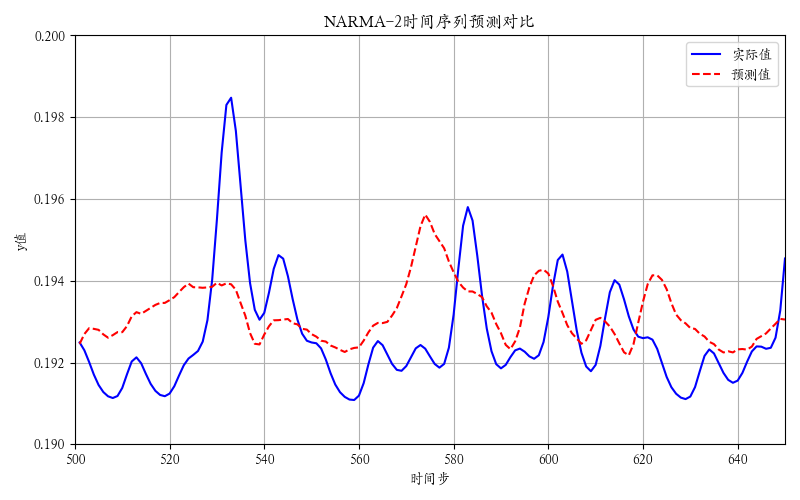

In [168]:
# 计算预测误差
mse = mean_squared_error(test_data, predictions)
print(f"测试集MSE: {mse}")

# 保存预测结果和实际值
np.save('/Users/dyy/github/QRC_project1/quantum_predictions.npy', predictions)
np.save('/Users/dyy/github/QRC_project1/actual_values.npy', test_data)

# 修改后的绘图代码（仅展示一维对比）
plt.figure(figsize=(8, 5))

# 生成时间步坐标（测试集从501到650）
time_steps = range(501, 651)

# 绘制实际值和预测值对比
plt.plot(time_steps, test_data, 'b-', linewidth=1.5, label='实际值')
plt.plot(time_steps, predictions, 'r--', linewidth=1.5, label='预测值')

# 添加图注和标签
plt.title('NARMA-2时间序列预测对比')
plt.xlabel('时间步')
plt.ylabel('y值')
plt.legend()
plt.grid(True)

# 调整坐标轴范围
plt.xlim(500, 650)
plt.ylim(0.19, 0.2)  # 仅显示0.19到0.2区间

# 保存并显示图像
plt.tight_layout()
plt.savefig('/Users/dyy/github/QRC_project1/narma_prediction_comparison.png')
plt.show()